In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
!pip install pandas_ta alpha_vantage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=4f72492783a75076c066f141bb733d58580b9231c4db9a934bac98af1b2e9e97
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


## LOADING DATA

In [ ]:
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from alpha_vantage.techindicators import TechIndicators

ALPHA_VANTAGE_API_KEY = "5S8XIDRZAHPI2ZB5"
ti = TechIndicators(key=ALPHA_VANTAGE_API_KEY, output_format="pandas")

aapl = yf.Ticker("AAPL")
ohlc_data = aapl.history(start="2023-01-01", end="2025-02-08")

ohlc_data = ohlc_data.rename(columns={
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Close": "Close",
    "Volume": "Volume",
    "Adj Close": "Adj Close"
})

ohlc_data.index = ohlc_data.index.tz_localize(None)
ohlc_data["SMA_50"] = ohlc_data["Close"].rolling(window=50).mean()
ohlc_data["EMA_50"] = ohlc_data["Close"].ewm(span=50, adjust=False).mean()
ohlc_data.ta.macd(append=True)
ohlc_data.ta.rsi(length=14, append=True)
ohlc_data["OBV"] = ohlc_data["Volume"].copy()
for i in range(1, len(ohlc_data)):
    if ohlc_data.iloc[i]["Close"] > ohlc_data.iloc[i - 1]["Close"]:
        ohlc_data.iloc[i, ohlc_data.columns.get_loc("OBV")] += ohlc_data.iloc[i - 1]["OBV"]
    elif ohlc_data.iloc[i]["Close"] < ohlc_data.iloc[i - 1]["Close"]:
        ohlc_data.iloc[i, ohlc_data.columns.get_loc("OBV")] -= ohlc_data.iloc[i - 1]["OBV"]

ohlc_data["Money Flow Multiplier"] = ((ohlc_data["Close"] - ohlc_data["Low"]) - (ohlc_data["High"] - ohlc_data["Close"])) / (ohlc_data["High"] - ohlc_data["Low"])
ohlc_data["Money Flow Volume"] = ohlc_data["Money Flow Multiplier"] * ohlc_data["Volume"]
ohlc_data["ADI"] = ohlc_data["Money Flow Volume"].cumsum()


final_columns = [
    "Open", "High", "Low", "Close", "Volume", "Adj Close",
    "SMA_50", "EMA_50", "MACD_12_26_9", "RSI_14",
    "OBV", "ADI"
]

existing_columns = [col for col in final_columns if col in ohlc_data.columns]
ohlc_data = ohlc_data[existing_columns]
ohlc_data = ohlc_data.dropna()

final_file_path = "AAPL_Final_Stock_Data_2023_2025.csv"
ohlc_data.to_csv(final_file_path, index=True)

print(f"✅ Final Dataset Saved: {final_file_path}")
print(f"📊 Removed rows with missing data.")
print(f"📊 Final Dataset Shape: {ohlc_data.shape}")
print(ohlc_data.head())


✅ Final Dataset Saved: AAPL_Final_Stock_Data_2023_2025.csv
📊 Removed rows with missing data.
📊 Final Dataset Shape: (478, 11)
                  Open        High         Low       Close    Volume  \
Date                                                                   
2023-03-15  149.680523  151.719954  148.423199  151.462555  77167900   
2023-03-16  150.640830  154.897901  150.126017  154.293991  76161100   
2023-03-17  154.521703  155.175117  152.739671  153.452484  98944600   
2023-03-20  153.521783  156.244326  152.610955  155.828506  73641400   
2023-03-21  155.749305  157.808525  154.977079  157.689728  73938300   

                SMA_50      EMA_50  MACD_12_26_9     RSI_14        OBV  \
Date                                                                     
2023-03-15  143.233809  143.469230      2.025517  58.385672 -282707300   
2023-03-16  143.847038  143.893731      2.269339  62.842890 -206546200   
2023-03-17  144.417934  144.268584      2.367379  60.759962  305490800   

## DATA PREPROCESSING

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_csv("AAPL_Final_Stock_Data_2023_2025.csv", index_col=0, parse_dates=True)
data = df[['Close']].values

data_min = data.min()
data_max = data.max()
data_scaled = (data - data_min) / (data_max - data_min)

seq_length = 60
X, y = [], []
for i in range(seq_length, len(data_scaled)):
    X.append(data_scaled[i - seq_length:i])
    y.append(data_scaled[i, 0])
X = np.array(X)
y = np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## TRANSFORMER MODEL

Training Transformer Model:
Transformer - Epoch 10/50, Loss: 0.018586
Transformer - Epoch 20/50, Loss: 0.010077
Transformer - Epoch 30/50, Loss: 0.007152
Transformer - Epoch 40/50, Loss: 0.004412
Transformer - Epoch 50/50, Loss: 0.003605

Transformer Evaluation Metrics:
RMSE: 3.457871570935859
MAE: 2.7287442684173584
MAPE: 1.16%


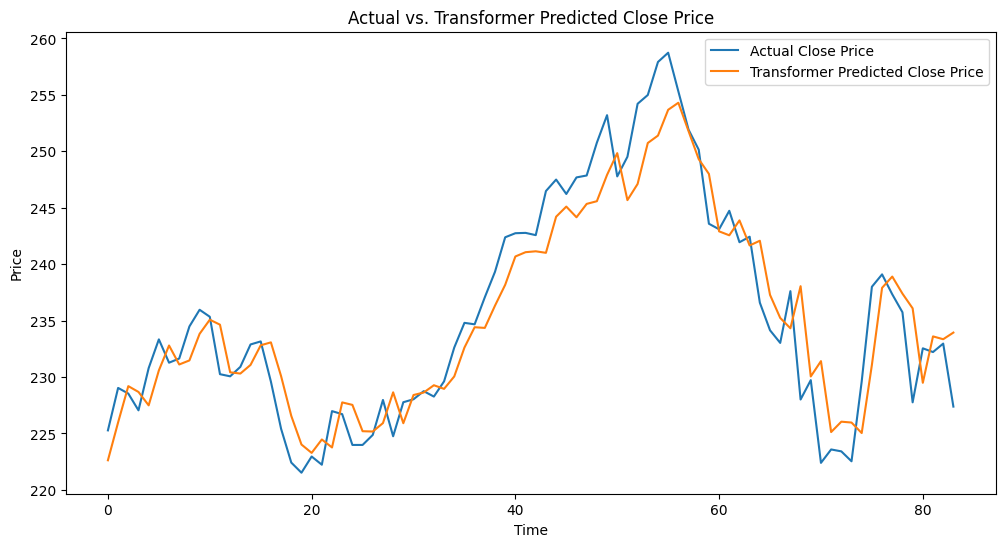

In [ ]:
class TransformerConfig:
    def __init__(self,
                 hidden_size=64,
                 num_hidden_layers=2,
                 num_attention_heads=4,
                 intermediate_size=128,
                 hidden_dropout_prob=0.1,
                 max_position_embeddings=100):
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.max_position_embeddings = max_position_embeddings

class NumericEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_size, max_seq_length, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_size)
        self.position_embeddings = nn.Embedding(max_seq_length, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear(x)
        batch_size, seq_length, _ = x.size()
        position_ids = torch.arange(seq_length, device=x.device).unsqueeze(0).expand(batch_size, seq_length)
        pos_emb = self.position_embeddings(position_ids)
        x = x + pos_emb
        x = self.layer_norm(x)
        x = self.dropout(x)
        return x

def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2))
    scores = scores / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.bmm(weights, value)
    return output

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        query = self.q(hidden_state)
        key = self.k(hidden_state)
        value = self.v(hidden_state)
        attn_output = scaled_dot_product_attention(query, key, value)
        return attn_output

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim) for _ in range(num_heads)])
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        head_outputs = [head(hidden_state) for head in self.heads]
        concatenated = torch.cat(head_outputs, dim=-1)
        output = self.output_linear(concatenated)
        return output

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.feed_forward = FeedForward(config)
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        attn_output = self.attention(x)
        x = self.layer_norm_1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.layer_norm_2(x + self.dropout(ff_output))
        return x

class SimpleTransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransformerPredictor(nn.Module):
    def __init__(self, config, input_dim, seq_length):
        super().__init__()
        self.embedding = NumericEmbedding(input_dim=input_dim,
                                          hidden_size=config.hidden_size,
                                          max_seq_length=seq_length,
                                          dropout=config.hidden_dropout_prob)
        self.encoder = SimpleTransformerEncoder(config)
        self.fc = nn.Linear(config.hidden_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        last_token = x[:, -1, :]
        out = self.fc(last_token)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trans_config = TransformerConfig(hidden_size=64,
                                 num_hidden_layers=2,
                                 num_attention_heads=8,
                                 intermediate_size=128,
                                 hidden_dropout_prob=0.1,
                                 max_position_embeddings=seq_length)

model_transformer = TransformerPredictor(trans_config, input_dim=1, seq_length=seq_length).to(device)

lr = 1e-4
optimizer_trans = torch.optim.Adam(model_transformer.parameters(), lr=lr)

criterion = nn.MSELoss()

num_epochs = 50
batch_size = 8

def train_model(model, optimizer, name):
    model.train()
    for epoch in range(num_epochs):
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0.0
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        epoch_loss /= X_train.size(0)
        if (epoch+1) % 10 == 0:
            print(f"{name} - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

print("Training Transformer Model:")
train_model(model_transformer, optimizer_trans, "Transformer")


model_transformer.eval()

with torch.no_grad():
    preds_trans = model_transformer(X_test.to(device)).cpu().numpy()

ensemble_preds = (preds_trans)

def inverse_scale(values, data_min, data_max):
    return values * (data_max - data_min) + data_min

predicted_prices = inverse_scale(ensemble_preds, data_min, data_max)
actual_prices = inverse_scale(y_test.cpu().numpy(), data_min, data_max)

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("\nTransformer Evaluation Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE: {:.2f}%".format(mape))

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Close Price")
plt.plot(predicted_prices, label="Transformer Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. Transformer Predicted Close Price")
plt.legend()
plt.show()


## GRU

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(



Training GRU Model:
GRU - Epoch 10/50, Loss: 0.001605
GRU - Epoch 20/50, Loss: 0.001040
GRU - Epoch 30/50, Loss: 0.000916
GRU - Epoch 40/50, Loss: 0.000756
GRU - Epoch 50/50, Loss: 0.000848

GRU Evaluation Metrics:
RMSE: 3.2720698228488563
MAE: 2.5558719635009766
MAPE: 1.09%


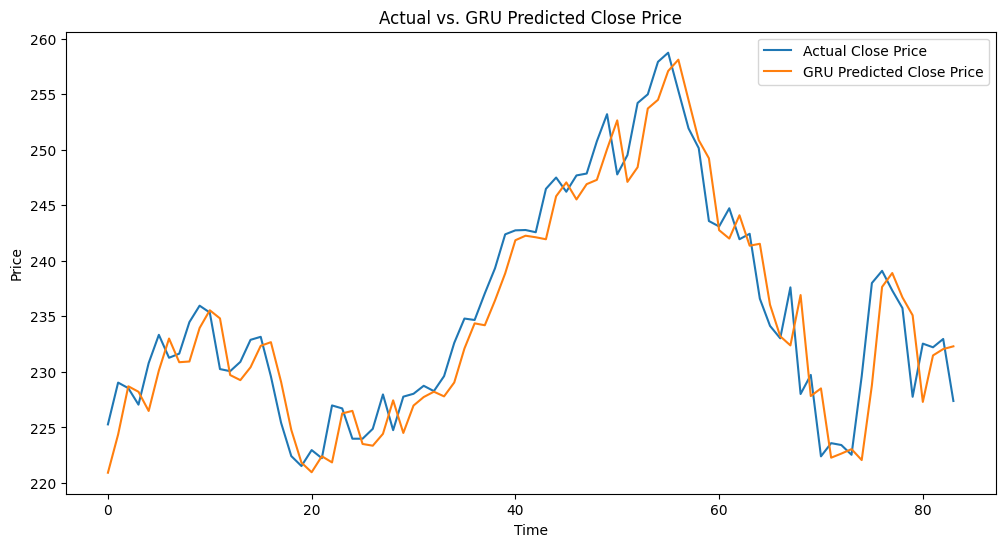

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn

class GRUPredictor(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, dropout):
        super(GRUPredictor, self).__init__()

        self.gru1 = nn.GRU(input_dim, hidden_size, num_layers=1, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(hidden_size, hidden_size, num_layers=1, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru1(x)
        out, _ = self.gru2(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gru = GRUPredictor(input_dim=1, hidden_size=256, num_layers=2, dropout=0.3).to(device)

lr = 1e-4

optimizer_gru   = torch.optim.Adam(model_gru.parameters(), lr=lr)
criterion = nn.MSELoss()

num_epochs = 50
batch_size = 4

def train_model(model, optimizer, name):
    model.train()
    for epoch in range(num_epochs):
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0.0
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        epoch_loss /= X_train.size(0)
        if (epoch+1) % 10 == 0:
            print(f"{name} - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

print("\nTraining GRU Model:")
train_model(model_gru, optimizer_gru, "GRU")


model_gru.eval()
with torch.no_grad():
    preds_gru   = model_gru(X_test.to(device)).cpu().numpy()

ensemble_preds = preds_gru

def inverse_scale(values, data_min, data_max):
    return values * (data_max - data_min) + data_min

predicted_prices = inverse_scale(ensemble_preds, data_min, data_max)
actual_prices = inverse_scale(y_test.cpu().numpy(), data_min, data_max)

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("\nGRU Evaluation Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE: {:.2f}%".format(mape))

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Close Price")
plt.plot(predicted_prices, label="GRU Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. GRU Predicted Close Price")
plt.legend()
plt.show()


# LSTM

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(



Training LSTM Model:
LSTM - Epoch 10/40, Loss: 0.001746
LSTM - Epoch 20/40, Loss: 0.001347
LSTM - Epoch 30/40, Loss: 0.001154
LSTM - Epoch 40/40, Loss: 0.000888

LSTM Evaluation Metrics:
RMSE: 3.6594642791151313
MAE: 2.8679146766662598
MAPE: 1.22%


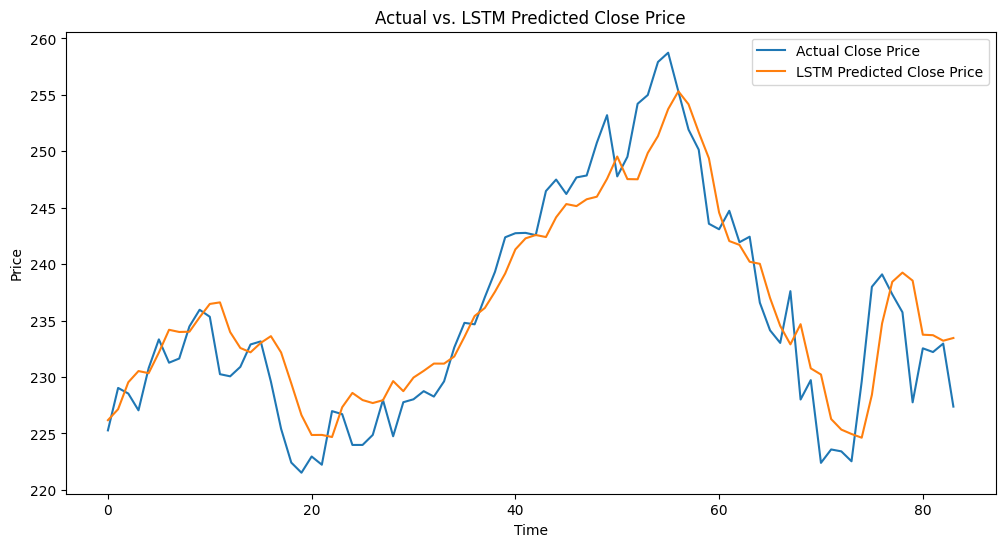

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn

import torch
import torch.nn as nn

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, dropout):
        super(LSTMPredictor, self).__init__()

        self.lstm1 = nn.LSTM(input_dim, hidden_size, num_layers=1,
                             batch_first=True, dropout=dropout, bidirectional=True)

        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=1,
                             batch_first=True, dropout=dropout, bidirectional=True)

        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        last_out = out[:, -1, :]
        out = self.fc(last_out)
        return out



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_lstm = LSTMPredictor(input_dim=1, hidden_size=256, num_layers=2, dropout=0.3).to(device)

lr = 1e-4

optimizer_lstm  = torch.optim.Adam(model_lstm.parameters(), lr=lr)

criterion = nn.MSELoss()

num_epochs = 40
batch_size = 4
def train_model(model, optimizer, name):
    model.train()
    for epoch in range(num_epochs):
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0.0
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        epoch_loss /= X_train.size(0)
        if (epoch+1) % 10 == 0:
            print(f"{name} - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")


print("\nTraining LSTM Model:")
train_model(model_lstm, optimizer_lstm, "LSTM")

model_transformer.eval()
model_lstm.eval()
model_gru.eval()
with torch.no_grad():
    preds_trans = model_transformer(X_test.to(device)).cpu().numpy()
    preds_lstm  = model_lstm(X_test.to(device)).cpu().numpy()
    preds_gru   = model_gru(X_test.to(device)).cpu().numpy()

ensemble_preds = preds_lstm

def inverse_scale(values, data_min, data_max):
    return values * (data_max - data_min) + data_min

predicted_prices = inverse_scale(ensemble_preds, data_min, data_max)
actual_prices = inverse_scale(y_test.cpu().numpy(), data_min, data_max)

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("\nLSTM Evaluation Metrics:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE: {:.2f}%".format(mape))

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Close Price")
plt.plot(predicted_prices, label="LSTM Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. LSTM Predicted Close Price")
plt.legend()
plt.show()
